# Google Merchamdise Store Data Analysis Exercise #

## Data Import, Analysis, and Preparation

Using the publicly available data from the Google Merchandise Store, we will be analyzing the data and generating a model to predict the visitors likely to make a purchase the following month.
This notebook will demonstrate the loading and conversion of data, the model training and model evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
from google.cloud import bigquery
client = bigquery.Client()

To be able to train the model, we need enough data. To keep the computational time reasonable but have enough data for the model to be more accurate, I have chosen a sample of 3 months. I have chosen to start the training set from the 1st of March and will use a loop to concatenate the rest of the days to the created data frame.

I will also be using the month of June as the test data.

To make it simpler for checking whether a visitor made a purchase the following month, I will create a data frame for each month. One the checks have been done (if a visitor from March made a purchase in April, a visitor in April made a purchase in May, etc.), I will combine the March, April and May data frames and that will serve as our training variables.
A similar process will be done for the test data.

In [2]:
from datetime import date, timedelta, datetime

training_sql_march = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_20170301"
training_df_march = client.query(training_sql_march).to_dataframe()

march_start_date = date(2017, 3, 2)
march_end_date = date(2017, 3, 31)
day = timedelta(days = 1)

while march_start_date <= march_end_date:
    date_string_march = march_start_date.strftime("%Y%m%d")
    google_data_march = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_"+ date_string_march
    temp_df_march = client.query(google_data_march).to_dataframe()
    training_df_march = pd.concat([training_df_march, temp_df_march], ignore_index=True) 
    march_start_date = march_start_date + day

In [3]:
training_sql_april = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_20170401"
training_df_april = client.query(training_sql_april).to_dataframe()

april_start_date = date(2017, 4, 2)
april_end_date = date(2017, 4, 30)
day = timedelta(days = 1)

while april_start_date <= april_end_date:
    date_string_april = april_start_date.strftime("%Y%m%d")
    google_data_april = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_"+ date_string_april
    temp_df_april = client.query(google_data_april).to_dataframe()
    training_df_april = pd.concat([training_df_april, temp_df_april], ignore_index=True) 
    april_start_date = april_start_date + day

In [4]:
training_sql_may = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_20170501"
training_df_may = client.query(training_sql_may).to_dataframe()

may_start_date = date(2017, 5, 2)
may_end_date = date(2017, 5, 31)
day = timedelta(days = 1)

while may_start_date <= may_end_date:
    date_string_may = may_start_date.strftime("%Y%m%d")
    google_data_may = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_"+ date_string_may
    temp_df_may = client.query(google_data_may).to_dataframe()
    training_df_may = pd.concat([training_df_may, temp_df_may], ignore_index=True) 
    may_start_date = may_start_date + day

In [5]:
testing_sql_june = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_20170601"
testing_df_june = client.query(testing_sql_june).to_dataframe()

june_start_date = date(2017, 6, 2)
june_end_date = date(2017, 6, 30)
day = timedelta(days = 1)

while june_start_date <= june_end_date:
    date_string_june = june_start_date.strftime("%Y%m%d")
    google_data_june = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_"+ date_string_june
    temp_df_june = client.query(google_data_june).to_dataframe()
    testing_df_june = pd.concat([testing_df_june, temp_df_june], ignore_index=True) 
    june_start_date = june_start_date + day

In [6]:
testing_sql_july = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_20170701"
testing_df_july = client.query(testing_sql_july).to_dataframe()

july_start_date = date(2017, 7, 2)
july_end_date = date(2017, 7, 31)
day = timedelta(days = 1)

while july_start_date <= july_end_date:
    date_string_july = july_start_date.strftime("%Y%m%d")
    google_data_july = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_"+ date_string_july
    temp_df_july = client.query(google_data_july).to_dataframe()
    testing_df_july = pd.concat([testing_df_july, temp_df_july], ignore_index=True) 
    july_start_date = july_start_date + day

Now that the training data frame has been created, we need to understand what type of data is stored in each column and what we want to use as variables for the machine learning model. We can learn more about what is stored in the data frame by looking at the dataset schema, provided by Google ("https://support.google.com/analytics/answer/3437719?hl=en").
There are multiple variables that can affect whether a visitor will be making a purchase. Based on the schema, I believe that the following variable types are required to train the model:

1. Information about the number of visits the user has made on the website.
2. The number of pages the visitor has viewed, how long the visitor stayed on the website and total number of hits on the website.
3. Time of day the visitor visited the sire
4. Geographical data, as well as device data of the visitor.
5. Session Quality which calculates how close a visitor was to purchasing.

As some of the data we need is nested inside the columns, we will need to identify which columns we need to keep and which columns to drop first, and then expand the data that is nested.

The same data is required for the testing data frame.

In [7]:
training_df_march_v1 = training_df_march[['fullVisitorId', 'date', 'visitStartTime', 'totals', 'device', 'geoNetwork', 'socialEngagementType', 'trafficSource']]
training_df_april_v1 = training_df_april[['fullVisitorId', 'date', 'visitStartTime', 'totals', 'device', 'geoNetwork', 'socialEngagementType', 'trafficSource']]
training_df_may_v1 = training_df_may[['fullVisitorId', 'date', 'visitStartTime', 'totals', 'device', 'geoNetwork', 'socialEngagementType', 'trafficSource']]
testing_df_june_v1 = testing_df_june[['fullVisitorId', 'date', 'visitStartTime', 'totals', 'device', 'geoNetwork', 'socialEngagementType', 'trafficSource']]
testing_df_july_v1 = testing_df_july[['fullVisitorId', 'date', 'visitStartTime', 'totals', 'device', 'geoNetwork', 'socialEngagementType', 'trafficSource']]

Now, the columns for 'totals', 'device', 'trafficSource' and 'geoNetworks' need to be expanded, as they have nested data in them. The columns each contain a dictionary as a value per row. We will turn the dictionary into a data frame and add it to the training_df_clean_v1 data frame, dropping the original columns in the process. The same is applied to the testing data frame.

In [8]:
columns = ('totals', 'trafficSource', 'device', 'geoNetwork')

for column in columns:
    df1_march = training_df_march_v1[column].apply(pd.Series)
    temp_str_march = column + '_'
    df1_march.columns = [temp_str_march + col_name for col_name in df1_march.columns]
    training_df_march_v1 = pd.concat([training_df_march_v1, df1_march], axis = 1)
    training_df_march_v1.drop([column], axis=1, inplace = True)

print(training_df_march_v1.shape)

(69931, 54)


In [9]:
for column in columns:
    df1_april = training_df_april_v1[column].apply(pd.Series)
    temp_str_april = column + '_'
    df1_april.columns = [temp_str_april + col_name for col_name in df1_april.columns]
    training_df_april_v1 = pd.concat([training_df_april_v1, df1_april], axis = 1)
    training_df_april_v1.drop([column], axis=1, inplace = True)

print(training_df_april_v1.shape)

(67126, 54)


In [10]:
for column in columns:
    df1_may = training_df_may_v1[column].apply(pd.Series)
    temp_str_may = column + '_'
    df1_may.columns = [temp_str_may + col_name for col_name in df1_may.columns]
    training_df_may_v1 = pd.concat([training_df_may_v1, df1_may], axis = 1)
    training_df_may_v1.drop([column], axis=1, inplace = True)

print(training_df_may_v1.shape)

(65371, 54)


In [11]:
for column in columns:
    df1_june = testing_df_june_v1[column].apply(pd.Series)
    temp_str_june = column + '_'
    df1_june.columns = [temp_str_june + col_name for col_name in df1_june.columns]
    testing_df_june_v1 = pd.concat([testing_df_june_v1, df1_june], axis = 1)
    testing_df_june_v1.drop([column], axis=1, inplace = True)

print(testing_df_june_v1.shape)

(63578, 54)


In [12]:
for column in columns:
    df1_july = testing_df_july_v1[column].apply(pd.Series)
    temp_str_july = column + '_'
    df1_july.columns = [temp_str_july + col_name for col_name in df1_july.columns]
    testing_df_july_v1 = pd.concat([testing_df_july_v1, df1_july], axis = 1)
    testing_df_july_v1.drop([column], axis=1, inplace = True)

print(testing_df_july_v1.shape)

(71812, 54)


After the information stored inside the 'totals', 'device', 'trafficSource' and 'geoNetworks' columns has been extracted and brought to the top level, we can further remove the columns that we do not want to use for training the model. Again, the decision has been made by reviewing what kind of data is stored in each column and making assumptions as to what information might be relevant to a new visitor purchasing from the Google Merchandise store.

In [13]:
training_df_march_v1 = training_df_march_v1[['fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions']]
training_df_april_v1 = training_df_april_v1[['fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions']]
training_df_may_v1 = training_df_may_v1[['fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions']]
testing_df_june_v1 = testing_df_june_v1[['fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions']]
testing_df_july_v1 = testing_df_july_v1[['fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions']]

I am creating simplified versions of the above data frames, which will include only the fullVisitorID and totals_transactions so that I can compare the current month with the next month and see if the same visitor ID made a purchase. For the purpose of training the model, we will check if visitors in March, April and May made purchases respectively on April, May and June. For the purpose of testing the model, we will check if visitors in June made purchases in July.

In [14]:
purchase_april =  training_df_april_v1[['fullVisitorId', 'totals_transactions']]
purchase_may =  training_df_may_v1[['fullVisitorId', 'totals_transactions']]
purchase_june =  testing_df_june_v1[['fullVisitorId', 'totals_transactions']]
purchase_july =  testing_df_july_v1[['fullVisitorId', 'totals_transactions']]

In [15]:
purchase_april = purchase_april.copy()
purchase_april['totals_transactions'] =  purchase_april['totals_transactions'].fillna(0)
purchase_may = purchase_may.copy()
purchase_may['totals_transactions'] =  purchase_may['totals_transactions'].fillna(0)
purchase_june = purchase_june.copy()
purchase_june['totals_transactions'] =  purchase_june['totals_transactions'].fillna(0)
purchase_july = purchase_july.copy()
purchase_july['totals_transactions'] = purchase_july['totals_transactions'].fillna(0)
purchase_april.describe(include='all')

,fullVisitorId,totals_transactions
count,67126,67126.000000
unique,55681,NaN
top,3148617623907142276,NaN
freq,42,NaN
mean,NaN,0.014287
std,NaN,0.122986
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


In [16]:
training_df_march_v1['nextMonthTransaction'] = training_df_march_v1['fullVisitorId'].isin(purchase_april['fullVisitorId'])
training_df_march_v1['nextMonthTransaction'] = training_df_march_v1['nextMonthTransaction'].astype(int)

for i in range(training_df_march_v1.shape[0]):
    if training_df_march_v1.loc[i, 'nextMonthTransaction'] == 0:
        training_df_march_v1.loc[i, 'nextMonthTransaction'] = 0
    else:
        training_df_march_v1.loc[i, 'nextMonthTransaction'] = purchase_april.loc[purchase_april['fullVisitorId'] == training_df_march_v1.loc[i, 'fullVisitorId'], 'totals_transactions'].sum()

In [17]:
training_df_april_v1['nextMonthTransaction'] = training_df_april_v1['fullVisitorId'].isin(purchase_may['fullVisitorId'])
training_df_april_v1['nextMonthTransaction'] = training_df_april_v1['nextMonthTransaction'].astype(int)

for i in range(training_df_april_v1.shape[0]):
    if training_df_april_v1.loc[i, 'nextMonthTransaction'] == 0:
        training_df_april_v1.loc[i, 'nextMonthTransaction'] = 0
    else:
        training_df_april_v1.loc[i, 'nextMonthTransaction'] = purchase_may.loc[purchase_may['fullVisitorId'] == training_df_april_v1.loc[i, 'fullVisitorId'], 'totals_transactions'].sum()

In [18]:
training_df_may_v1['nextMonthTransaction'] = training_df_may_v1['fullVisitorId'].isin(purchase_june['fullVisitorId'])
training_df_may_v1['nextMonthTransaction'] = training_df_may_v1['nextMonthTransaction'].astype(int)

for i in range(training_df_may_v1.shape[0]):
    if training_df_may_v1.loc[i, 'nextMonthTransaction'] == 0:
        training_df_may_v1.loc[i, 'nextMonthTransaction'] = 0
    else:
        training_df_may_v1.loc[i, 'nextMonthTransaction'] = purchase_june.loc[purchase_june['fullVisitorId'] == training_df_may_v1.loc[i, 'fullVisitorId'], 'totals_transactions'].sum()

In [19]:
testing_df_june_v1['nextMonthTransaction'] = testing_df_june_v1['fullVisitorId'].isin(purchase_july['fullVisitorId'])
testing_df_june_v1['nextMonthTransaction'] = testing_df_june_v1['nextMonthTransaction'].astype(int)

for i in range(testing_df_june_v1.shape[0]):
    if testing_df_june_v1.loc[i, 'nextMonthTransaction'] == 0:
        testing_df_june_v1.loc[i, 'nextMonthTransaction'] = 0
    else:
        testing_df_june_v1.loc[i, 'nextMonthTransaction'] = purchase_july.loc[purchase_july['fullVisitorId'] == testing_df_june_v1.loc[i, 'fullVisitorId'], 'totals_transactions'].sum()

As we have the complete monthly data frame, which now include if a user has made a purchase in the following month, we can combine the March, April and May data frames to form the training data frame. While the June data frame will be our testing data frame.

In [20]:
training_df_clean_v1 = pd.concat([training_df_march_v1, training_df_april_v1], ignore_index=True)
training_df_clean_v1 = pd.concat([training_df_clean_v1, training_df_may_v1], ignore_index=True)

In [21]:
training_df_clean_v2 = training_df_clean_v1[['fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions', 'nextMonthTransaction']]
training_df_clean_v2.shape

(202428, 18)

In [22]:
testing_df_clean_v2 = testing_df_june_v1[['fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions', 'nextMonthTransaction']]
testing_df_clean_v2.shape

(63578, 18)

Now, we can look at the simple .describe() function for our data frame and further decide if more columns need to be dropped.

In [23]:
training_df_clean_v2.describe(include='all')

,fullVisitorId,date,visitStartTime,socialEngagementType,totals_hits,totals_visits,totals_pageviews,totals_timeOnSite,totals_sessionQualityDim,device_browser,device_operatingSystem,device_deviceCategory,geoNetwork_country,geoNetwork_city,geoNetwork_cityId,trafficSource_source,totals_transactions,nextMonthTransaction
count,202428,202428,202428.0,202428,202428.000000,202428.0,202409.000000,100483.000000,0.0,202428,202428,202428,202428,202428,202428,202428,2926.000000,202428.000000
unique,160670,92,<NA>,1,NaN,NaN,NaN,NaN,NaN,34,16,3,200,334,1,168,NaN,NaN
top,1957458976293878100,20170426,<NA>,Not Socially Engaged,NaN,NaN,NaN,NaN,NaN,Chrome,Windows,desktop,United States,not available in demo dataset,not available in demo dataset,google,NaN,NaN
freq,95,4224,<NA>,202428,NaN,NaN,NaN,NaN,NaN,145411,76470,138412,86210,115185,202428,100875,NaN,NaN
mean,NaN,NaN,1492264822.885984,NaN,4.391576,1.0,3.740817,286.130470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.063568,0.010833
std,NaN,NaN,2266648.468223,NaN,8.608385,0.0,6.457006,497.604844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.741488,0.207589
min,NaN,NaN,1488355235.0,NaN,1.000000,1.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,NaN,1490303290.25,NaN,1.000000,1.0,1.000000,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
50%,NaN,NaN,1492200351.0,NaN,2.000000,1.0,1.000000,98.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
75%,NaN,NaN,1494194515.75,NaN,4.000000,1.0,4.000000,301.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000


In [24]:
check_na_df = training_df_clean_v2.isna()
columns = ('fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions', 'nextMonthTransaction')

for column in columns:
    print(check_na_df[column].value_counts())

fullVisitorId
False    202428
Name: count, dtype: int64
date
False    202428
Name: count, dtype: int64
visitStartTime
False    202428
Name: count, dtype: int64
socialEngagementType
False    202428
Name: count, dtype: int64
totals_hits
False    202428
Name: count, dtype: int64
totals_visits
False    202428
Name: count, dtype: int64
totals_pageviews
False    202409
True         19
Name: count, dtype: int64
totals_timeOnSite
True     101945
False    100483
Name: count, dtype: int64
totals_sessionQualityDim
True    202428
Name: count, dtype: int64
device_browser
False    202428
Name: count, dtype: int64
device_operatingSystem
False    202428
Name: count, dtype: int64
device_deviceCategory
False    202428
Name: count, dtype: int64
geoNetwork_country
False    202428
Name: count, dtype: int64
geoNetwork_city
False    202428
Name: count, dtype: int64
geoNetwork_cityId
False    202428
Name: count, dtype: int64
trafficSource_source
False    202428
Name: count, dtype: int64
totals_transactions
Tr

From the describe function, we see that the following columns will not provide much data and may even obscure our results, thus must be removed:
1. socialEngagementType only has one value, does not provide any additional information.
2. geoNetwork_cityId only has one value, does not provide any additional information.
3. geoNetwork_city has many unique values (281), but more than half of the entries are "not available in demo dataset". Since we can keep the country information, as it is more complete, this column can be dropped.
4. totals_sessionQualityDim only includes NaN values and needs to be dropped.
5. totals_timeOnSite has half of the values missing. Replacing the NaN values will compromise the results. Due to this, this column needs to be dropped.

totals_pageviews only includes very few NaN values, thus these can be replaced by the mean of the column without compromising the results of the modeling substantially.
From the description Google provides, we can safely assume that if no transaction occurred, then NaN is stored in the column totals_transactions. Therefore, all NaN values in this column can be replaced with 0.

As the test variables need to match the training variables, all these columns need to be removed for the testing data frame as well.

In [25]:
training_df_clean_v2 = training_df_clean_v2.copy()
training_df_clean_v2.drop(['socialEngagementType'], axis=1, inplace = True)
training_df_clean_v2.drop(['geoNetwork_cityId'], axis=1, inplace = True)
training_df_clean_v2.drop(['geoNetwork_city'], axis=1, inplace = True)
training_df_clean_v2.drop(['totals_sessionQualityDim'], axis=1, inplace = True)
training_df_clean_v2.drop(['totals_timeOnSite'], axis=1, inplace = True)
training_df_clean_v2.describe(include='all')

,fullVisitorId,date,visitStartTime,totals_hits,totals_visits,totals_pageviews,device_browser,device_operatingSystem,device_deviceCategory,geoNetwork_country,trafficSource_source,totals_transactions,nextMonthTransaction
count,202428,202428,202428.0,202428.000000,202428.0,202409.000000,202428,202428,202428,202428,202428,2926.000000,202428.000000
unique,160670,92,<NA>,NaN,NaN,NaN,34,16,3,200,168,NaN,NaN
top,1957458976293878100,20170426,<NA>,NaN,NaN,NaN,Chrome,Windows,desktop,United States,google,NaN,NaN
freq,95,4224,<NA>,NaN,NaN,NaN,145411,76470,138412,86210,100875,NaN,NaN
mean,NaN,NaN,1492264822.885984,4.391576,1.0,3.740817,NaN,NaN,NaN,NaN,NaN,1.063568,0.010833
std,NaN,NaN,2266648.468223,8.608385,0.0,6.457006,NaN,NaN,NaN,NaN,NaN,0.741488,0.207589
min,NaN,NaN,1488355235.0,1.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,NaN,1490303290.25,1.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
50%,NaN,NaN,1492200351.0,2.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
75%,NaN,NaN,1494194515.75,4.000000,1.0,4.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000


In [26]:
training_df_clean_v2.loc[training_df_clean_v2.duplicated()]

,fullVisitorId,date,visitStartTime,totals_hits,totals_visits,totals_pageviews,device_browser,device_operatingSystem,device_deviceCategory,geoNetwork_country,trafficSource_source,totals_transactions,nextMonthTransaction


In [27]:
testing_df_clean_v2 = testing_df_clean_v2.copy()
testing_df_clean_v2.drop(['socialEngagementType'], axis=1, inplace = True)
testing_df_clean_v2.drop(['geoNetwork_cityId'], axis=1, inplace = True)
testing_df_clean_v2.drop(['geoNetwork_city'], axis=1, inplace = True)
testing_df_clean_v2.drop(['totals_sessionQualityDim'], axis=1, inplace = True)
testing_df_clean_v2.drop(['totals_timeOnSite'], axis=1, inplace = True)
testing_df_clean_v2.describe(include='all')

,fullVisitorId,date,visitStartTime,totals_hits,totals_visits,totals_pageviews,device_browser,device_operatingSystem,device_deviceCategory,geoNetwork_country,trafficSource_source,totals_transactions,nextMonthTransaction
count,63578,63578,63578.0,63578.000000,63578.0,63571.000000,63578,63578,63578,63578,63578,946.000000,63578.000000
unique,52067,30,<NA>,NaN,NaN,NaN,26,12,3,183,103,NaN,NaN
top,0232377434237234751,20170601,<NA>,NaN,NaN,NaN,Chrome,Windows,desktop,United States,(direct),NaN,NaN
freq,44,2826,<NA>,NaN,NaN,NaN,45767,21607,42016,30351,37491,NaN,NaN
mean,NaN,NaN,1497622408.721476,4.324043,1.0,3.668497,NaN,NaN,NaN,NaN,NaN,1.026427,0.008273
std,NaN,NaN,772437.060402,7.846307,0.0,5.791259,NaN,NaN,NaN,NaN,NaN,0.201422,0.107276
min,NaN,NaN,1496300415.0,1.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,NaN,1496936829.0,1.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
50%,NaN,NaN,1497597722.0,2.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
75%,NaN,NaN,1498294196.75,4.000000,1.0,4.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000


To make sure that the testing data frame has no NaN values that need replacing, we will proceed with the checks for this data frame as well.

In [28]:
check_na_df = testing_df_clean_v2.isna()
columns = ('fullVisitorId', 'date', 'visitStartTime', 'totals_hits', 'totals_visits', 'totals_pageviews','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'trafficSource_source', 'totals_transactions')

for column in columns:
    print(check_na_df[column].value_counts())

fullVisitorId
False    63578
Name: count, dtype: int64
date
False    63578
Name: count, dtype: int64
visitStartTime
False    63578
Name: count, dtype: int64
totals_hits
False    63578
Name: count, dtype: int64
totals_visits
False    63578
Name: count, dtype: int64
totals_pageviews
False    63571
True         7
Name: count, dtype: int64
device_browser
False    63578
Name: count, dtype: int64
device_operatingSystem
False    63578
Name: count, dtype: int64
device_deviceCategory
False    63578
Name: count, dtype: int64
geoNetwork_country
False    63578
Name: count, dtype: int64
trafficSource_source
False    63578
Name: count, dtype: int64
totals_transactions
True     62632
False      946
Name: count, dtype: int64


In [29]:
testing_df_clean_v2.loc[testing_df_clean_v2.duplicated()]

,fullVisitorId,date,visitStartTime,totals_hits,totals_visits,totals_pageviews,device_browser,device_operatingSystem,device_deviceCategory,geoNetwork_country,trafficSource_source,totals_transactions,nextMonthTransaction


We see that for the testing data frame, totals_pageviews also has a few missing values. We can replace these for both the training and testing data frames before we proceed further. 

In [30]:
training_df_clean_v2['totals_pageviews'] = training_df_clean_v2['totals_pageviews'].fillna(training_df_clean_v2['totals_pageviews'].mean())
training_df_clean_v2['totals_transactions'] = training_df_clean_v2['totals_transactions'].fillna(0)
print(training_df_clean_v2['totals_pageviews'].isna().value_counts())
print(training_df_clean_v2['totals_transactions'].isna().value_counts())

totals_pageviews
False    202428
Name: count, dtype: int64
totals_transactions
False    202428
Name: count, dtype: int64


In [31]:
testing_df_clean_v2['totals_pageviews'] = testing_df_clean_v2['totals_pageviews'].fillna(testing_df_clean_v2['totals_pageviews'].mean())
testing_df_clean_v2['totals_transactions'] = testing_df_clean_v2['totals_transactions'].fillna(0)
print(testing_df_clean_v2['totals_pageviews'].isna().value_counts())
print(testing_df_clean_v2['totals_transactions'].isna().value_counts())

totals_pageviews
False    63578
Name: count, dtype: int64
totals_transactions
False    63578
Name: count, dtype: int64


Now that we have the data that we want to use for the model, we need to clean it up. Missing values need to be handled correctly, data stored as string may be better represented as integers, etc. 

From the date columns, interesting information for us may be the date of the month, as well as if the day falls on a weekend or not. For this, we use the date column to create two new columns dateDay and IsWeekend.

In [32]:
#For the training data:
date_data1 = pd.DataFrame({'dateDay': training_df_clean_v2['date'].astype(str).str[-2:].astype(int)})
for i in range(training_df_clean_v2.shape[0]):
    date_string = training_df_clean_v2.loc[i, 'date']
    as_date = datetime.strptime(date_string, "%Y%m%d")
    if as_date.weekday() >= 5:
        date_data1.loc[i, 'isWeekend'] = 1
    else:
        date_data1.loc[i, 'isWeekend'] = 0

In [33]:
#For the testing data:
date_data2 = pd.DataFrame({'dateDay': testing_df_clean_v2['date'].astype(str).str[-2:].astype(int)})
for i in range(testing_df_clean_v2.shape[0]):
    date_string = testing_df_clean_v2.loc[i, 'date']
    as_date = datetime.strptime(date_string, "%Y%m%d")
    if as_date.weekday() >= 5:
        date_data2.loc[i, 'isWeekend'] = 1
    else:
        date_data2.loc[i, 'isWeekend'] = 0

In [34]:
print(date_data1.describe())
print(date_data2.describe())

             dateDay      isWeekend
count  202428.000000  202428.000000
mean       15.821537       0.210850
std         8.929142       0.407913
min         1.000000       0.000000
25%         8.000000       0.000000
50%        16.000000       0.000000
75%        24.000000       0.000000
max        31.000000       1.000000
            dateDay     isWeekend
count  63578.000000  63578.000000
mean      15.804476      0.188163
std        8.933625      0.390845
min        1.000000      0.000000
25%        8.000000      0.000000
50%       16.000000      0.000000
75%       24.000000      0.000000
max       30.000000      1.000000


In [35]:
training_df_clean_v2.insert(2, 'dateDay', date_data1['dateDay'])
training_df_clean_v2.insert(3, 'isWeekend', date_data1['isWeekend'])
testing_df_clean_v2.insert(2, 'dateDay', date_data2['dateDay'])
testing_df_clean_v2.insert(3, 'isWeekend', date_data2['isWeekend'])

For the fullVisitorId, device_browser, device_operatingSystem, device_deviceCategory, geoNetwork_country and trafficSource_source, we will convert the text to a number in order to have it in a format more appropriate for the model. However, as we want to make sure that the information is kept the same across the training and testing data, we will create a big dictionary and have both data frame look at the same dictionary when mapping a string value to a number value.

In [36]:
columns = ('trafficSource_source', 'device_browser', 'device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country')
str_values_df = pd.DataFrame()

for column in columns:
    str_values_df[column] = pd.concat([training_df_clean_v2[column], testing_df_clean_v2[column]], ignore_index=True)

str_values_df.shape

(266006, 5)

In [37]:
training_df_clean_v2 = training_df_clean_v2.copy()

#For the training data:
for column in columns:
    temp_array = str_values_df[column].unique()
    index_of_not_set = np.where(temp_array == '(not set)')[0]
    temp_array = np.delete(temp_array, index_of_not_set)
    temp_dict = {}
    temp_dict['(not set)'] = 0
    
    if '0' in temp_array:
        index_of_0 = np.where(temp_array == '0')[0]
        temp_array = np.delete(temp_array, index_of_0)
        temp_dict['0'] = 0
    
    for i in range(len(temp_array)):
        temp_dict[temp_array[i]] = (i+1)
    temp_str = column + '_numeric'
    training_df_clean_v2[temp_str] = training_df_clean_v2[column].map(temp_dict)

In [38]:
testing_df_clean_v2 = testing_df_clean_v2.copy()

#For the testing data:
for string in columns:
    temp_array = str_values_df[string].unique()
    index_of_not_set = np.where(temp_array == '(not set)')[0]
    temp_array = np.delete(temp_array, index_of_not_set)
    temp_dict = {}
    temp_dict['(not set)'] = 0
    
    if '0' in temp_array:
        index_of_0 = np.where(temp_array == '0')[0]
        temp_array = np.delete(temp_array, index_of_0)
        temp_dict['0'] = 0
    
    for i in range(len(temp_array)):
        temp_dict[temp_array[i]] = (i+1)
    temp_str = string + '_numeric'
    testing_df_clean_v2[temp_str] = testing_df_clean_v2[string].map(temp_dict)

For the column 'visitStartTime', as it is presented in POSIX time, we need to understand what time of the day it was. The closest hour will do for this purpose. 

In [39]:
from datetime import timezone
training_df_clean_v2['visitStartTime_hour'] = 0
training_df_clean_v2 = training_df_clean_v2.copy()
for i in training_df_clean_v2.index:
    date = datetime.fromtimestamp(training_df_clean_v2.loc[i, 'visitStartTime'], tz=timezone.utc)
    training_df_clean_v2.loc[i, 'visitStartTime_hour'] = int(date.strftime('%H'))
    
testing_df_clean_v2['visitStartTime_hour'] = 0
testing_df_clean_v2 = testing_df_clean_v2.copy()
for i in testing_df_clean_v2.index:
    date = datetime.fromtimestamp(testing_df_clean_v2.loc[i, 'visitStartTime'], tz=timezone.utc)
    testing_df_clean_v2.loc[i, 'visitStartTime_hour'] = int(date.strftime('%H'))

We can now continue to create our target data frame and control data frame, by taking the information we previously saved in the column 'nextMonthTransaction'. As we  are only interested in whether a purchase was made or not, we will check the 'nextMonthTransaction' and set 'nextMonthTransaction_binary' to 0 if no purchase was made and to 1 if a purchase was made.

In [40]:
target_df = training_df_clean_v1[['nextMonthTransaction']]

target_df = target_df.copy()
for i in range(target_df.shape[0]):
    if target_df.loc[i, 'nextMonthTransaction'] == 0:
        target_df.loc[i, 'nextMonthTransaction_binary'] = 0
    else:
        target_df.loc[i, 'nextMonthTransaction_binary'] = 1

print(target_df['nextMonthTransaction_binary'].value_counts())

control_df = testing_df_june_v1[['nextMonthTransaction']]

control_df = control_df.copy()
for i in range(control_df.shape[0]):
    if control_df.loc[i, 'nextMonthTransaction'] == 0:
        control_df.loc[i, 'nextMonthTransaction_binary'] = 0
    else:
        control_df.loc[i, 'nextMonthTransaction_binary'] = 1

control_df['nextMonthTransaction_binary'].value_counts()

nextMonthTransaction_binary
0.0    201186
1.0      1242
Name: count, dtype: int64


nextMonthTransaction_binary
0.0    63135
1.0      443
Name: count, dtype: int64

To avoid that one variable has a higher impact on the model than another variable, it is best to have all of the columns fall between 0 and 1. This can be done using the Min-Max scaling method, which is available in the sklearn.preprocessing module.

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

columns = ('visitStartTime_hour', 'totals_pageviews', 'totals_hits', 'dateDay', 'trafficSource_source_numeric', 'device_browser_numeric', 'device_operatingSystem_numeric', 'device_deviceCategory_numeric', 'geoNetwork_country_numeric', 'totals_transactions')

for column in columns:
    training_df_clean_v2[column] = scaler.fit_transform(training_df_clean_v2[[column]])
    testing_df_clean_v2[column] = scaler.fit_transform(testing_df_clean_v2[[column]])

At this point, we have prepared the input variables, as well as the target variable. In machine learning terminology, we have the following datasets: 

- training_df_clean_v2 as the X_train: The data frame we will use as the variables training the machine learning model.
- testing_df_clean_v2 as the X_test: The data frame we will use as the variables testing the machine learning model, it has the same columns as X_train
- target_df as the Y_train: The data frame we will use as the target variables during the machine learning model training. It is known to the model and used to understand the relationships between the training variables and the target variable.
- control_df as the Y_test: The data frame we will use as the evaluator of our model, which uses X_train to provide predictions.

In [42]:
X_train = training_df_clean_v2[['dateDay', 'isWeekend', 'visitStartTime_hour', 'totals_hits', 'totals_pageviews', 'trafficSource_source_numeric', 'device_browser_numeric', 'device_operatingSystem_numeric', 'device_deviceCategory_numeric', 'geoNetwork_country_numeric', 'totals_transactions']]
X_test = testing_df_clean_v2[['dateDay', 'isWeekend', 'visitStartTime_hour', 'totals_hits', 'totals_pageviews', 'trafficSource_source_numeric', 'device_browser_numeric', 'device_operatingSystem_numeric', 'device_deviceCategory_numeric', 'geoNetwork_country_numeric', 'totals_transactions']]
Y_train = target_df[['nextMonthTransaction_binary']]
Y_test = control_df[['nextMonthTransaction_binary']]

## Model Testing

Now that we have all the data ready, we can start will choosing a model and programming it. There are multiple models that I would like to review:

1. Logistic Regression
2. Balanced Random Forest
3. Gradient Boosting Machines
4. Light Gradient Boosting Machines
5. eXtreme Boosting Machines
6. Gaussian Naive Bayes
7. Neural Networks

These are the most commonly used models for predicting and classification problems, which is the one we are trying to solve with this exercise.

### 1. Logistical Regression

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, Y_train.values.ravel())
Y_Pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(Y_test, Y_Pred_log_reg))

Logistic Regression Accuracy: 0.6500204473245462


The Logistic Regression Accuracy of 64.7% is not a very convincing number, to proceed with this model. To better show the performance of this model, we can visualize the Confusion Matrix, to show where the true and false positives / negatives are found.
A good model performance indicator is also the ROC-AUC curve, which we will also plot and interpret.

[[40921 22214]
 [   37   406]]


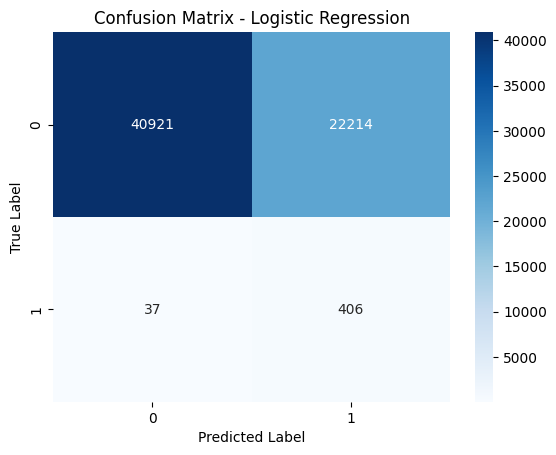

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(Y_test, Y_Pred_log_reg)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

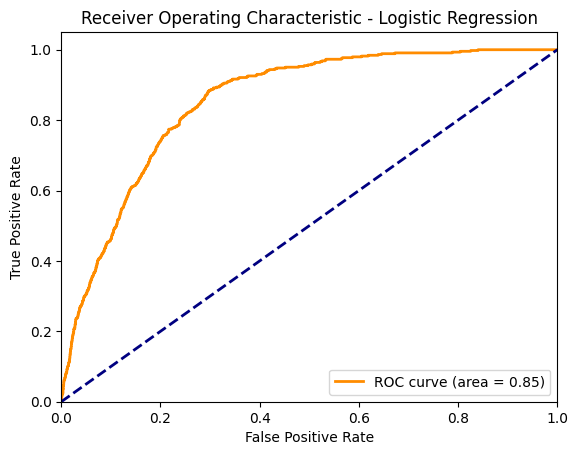

In [45]:
from sklearn.metrics import roc_curve, auc

Prob_log_reg = log_reg.predict_proba(X_test)[:, 1]
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(Y_test, Prob_log_reg)

roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_log_reg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

After testing with the standard version of the model, I added "class_weight = 'balanced'", in order to get a more accurate outcome. We can see that almost 1/3 of the cases when the Y_test has a value of 0, the model returned a 1. The accuracy is much better for the cases when Y_test has a value of 1. The ROC curve shows a nice curve, near the left and top borders, as is the aim. The AUC value is also quite high. 

All in all, although the accuracy rate is low, the performance of the model is not bad, but we can possibly achieve better results with different models as well.

### 2. Balanced Random Forest

In [46]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf_100 = BalancedRandomForestClassifier(n_estimators=100, random_state=42, sampling_strategy = 'all', replacement = True, bootstrap = False)

brf_100.fit(X_train, Y_train.values.ravel())

Y_Pred_brf_100 = brf_100.predict(X_test)
print("Balanced Random Forest Accuracy:", accuracy_score(Y_test, Y_Pred_brf_100))

Balanced Random Forest Accuracy: 0.8104061153229104


After testing with the Random Forest model and received very poor results, I decided to change to a Balanced Random Forest model, to account for the very unbalanced data. 
The Balanced Random Forest model has an accuracy of 84.9%, which is very high, but not the full picture.
For this model as well, we will plot the confusion matrix and the ROC-AUC curve.

[[51188 11947]
 [  107   336]]


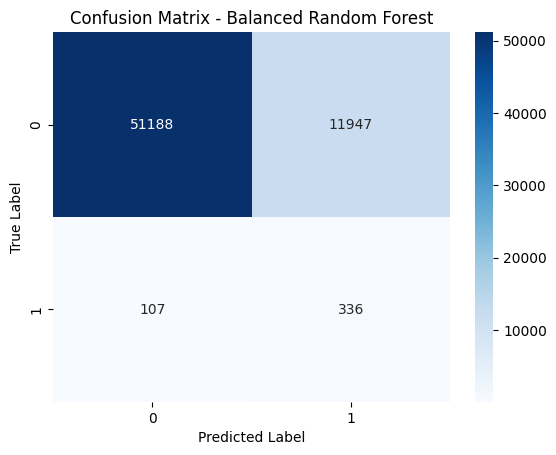

In [47]:
conf_matrix_brf_100 = confusion_matrix(Y_test, Y_Pred_brf_100)
print(conf_matrix_brf_100)
sns.heatmap(conf_matrix_brf_100, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Balanced Random Forest')
plt.show()

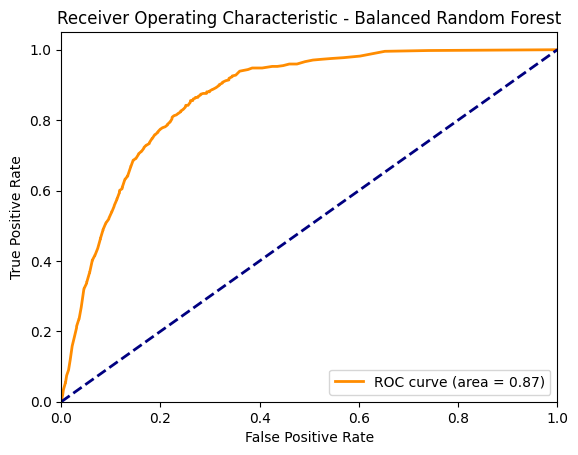

In [48]:
Prob_log_brf_100 = brf_100.predict_proba(X_test)[:, 1]
fpr_brf_100, tpr_brf_100, thresholds_brf_100 = roc_curve(Y_test, Prob_log_brf_100)

roc_auc_brf_100 = auc(fpr_brf_100, tpr_brf_100)

plt.figure()
plt.plot(fpr_brf_100, tpr_brf_100, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_brf_100)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Balanced Random Forest')
plt.legend(loc="lower right")
plt.show()

We see an increase in the accuracy score of the Balanced Random Forest model in comparison to the Logistic Regression model. It performed much better when clasifying Y_test = 0, but worse when classifying  Y_test = 1.

Note: while testing, I tried to change the n_estimators to the following values: 200, 500, 5000, to see if it made a difference, the results were the same. They were not included here.

### 3. Gradient Boosting Machines

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train.values.ravel())
gbm.fit(X_train_resampled, y_train_resampled)

Y_Pred_gbm = gbm.predict(X_test)

print("GBM Accuracy:", accuracy_score(Y_test, Y_Pred_gbm))

GBM Accuracy: 0.9171883355877819


The Gradient Boosting Machines have an even higher accuracy rate than the Balanced Random Forest Model, with an accuracy of 95.9%.
For this model as well, we will plot the confusion matrix and the ROC-AUC curve to understand the model behaviour better.

[[58169  4966]
 [  299   144]]


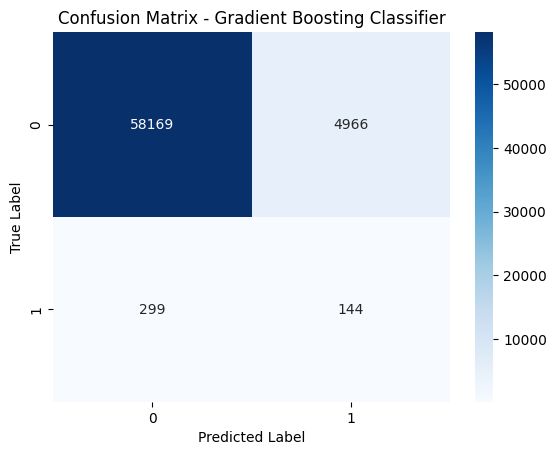

In [50]:
conf_matrix_gmb_100 = confusion_matrix(Y_test, Y_Pred_gbm)
print(conf_matrix_gmb_100)
sns.heatmap(conf_matrix_gmb_100, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.show()

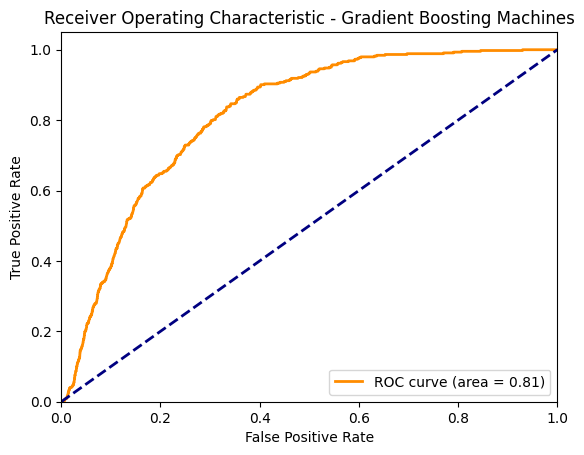

In [51]:
Prob_log_gbm = gbm.predict_proba(X_test)[:, 1]
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(Y_test, Prob_log_gbm)

roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

plt.figure()
plt.plot(fpr_gbm, tpr_gbm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gbm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Gradient Boosting Machines')
plt.legend(loc="lower right")
plt.show()

The GMB model, although shows higher accuracy, has a lower AUC value and flatter ROC curve in comparison to the Balanced Random Forest Model. 
There are multiple versions of GBMs that we can test to see how they perform in comparison to the GBM and BRF.

### 4. Light Gradient Boosting Machines

In [52]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(is_unbalance=True)
lgbm.fit(X_train, Y_train.values.ravel())

Y_Pred_light_gbm = lgbm.predict(X_test)

print("Light GBM Accuracy:", accuracy_score(Y_test, Y_Pred_light_gbm))

[LightGBM] [Info] Number of positive: 1242, number of negative: 201186
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 202428, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006136 -> initscore=-5.087507
[LightGBM] [Info] Start training from score -5.087507
Light GBM Accuracy: 0.839000912265249


The Light Gradient Boosting Machines have a lower accuracy rate than the Gradient Boosting Machines, with an accuracy of 82.5%.
For this model as well, we will plot the confusion matrix and the ROC-AUC curve to understand the model behaviour better.

[[53108 10027]
 [  209   234]]


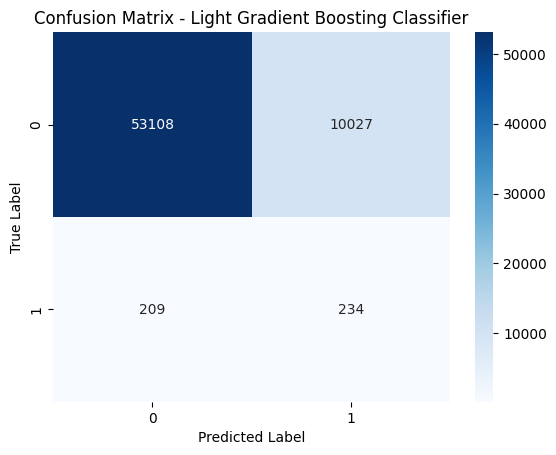

In [53]:
conf_matrix_light_gmb = confusion_matrix(Y_test, Y_Pred_light_gbm)
print(conf_matrix_light_gmb)
sns.heatmap(conf_matrix_light_gmb, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Light Gradient Boosting Classifier')
plt.show()

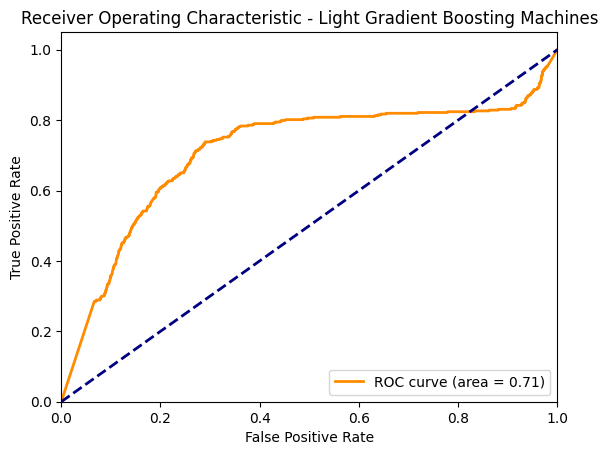

In [54]:
Prob_log_light_gbm = lgbm.predict_proba(X_test)[:, 1]
fpr_light_gbm, tpr_light_gbm, thresholds_light_gbm = roc_curve(Y_test, Prob_log_light_gbm)

roc_auc_light_gbm = auc(fpr_light_gbm, tpr_light_gbm)

plt.figure()
plt.plot(fpr_light_gbm, tpr_light_gbm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_light_gbm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Light Gradient Boosting Machines')
plt.legend(loc="lower right")
plt.show()

The LGBM model has a higher accuracy when predicting true positives in comparison to the GBM model, but also much lower accuracy when predicting true negatives. 
Given the ROC curve and the AUC value, we cannot consider the LGBM model for our exercise. 

### 5. eXtreme Gradient Boosting

In [55]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [56]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train.values.ravel())

dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test, label=Y_test.values.ravel())

In [57]:
params = {
    'max_depth': 5,
    'eta': 0.3, 
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss',
    'seed': 42 
}

In [58]:
num_round = 100  # the number of training iterations
bst = xgb.train(params, dtrain, num_round, [(dtest, 'test')])

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	test-logloss:0.51099
[1]	test-logloss:0.40455
[2]	test-logloss:0.36676
[3]	test-logloss:0.32637
[4]	test-logloss:0.30020
[5]	test-logloss:0.28779
[6]	test-logloss:0.28606
[7]	test-logloss:0.28648
[8]	test-logloss:0.28200
[9]	test-logloss:0.26806
[10]	test-logloss:0.25001
[11]	test-logloss:0.25066
[12]	test-logloss:0.23574
[13]	test-logloss:0.25122
[14]	test-logloss:0.24602
[15]	test-logloss:0.24472
[16]	test-logloss:0.22809
[17]	test-logloss:0.24854
[18]	test-logloss:0.24245
[19]	test-logloss:0.22980
[20]	test-logloss:0.22552
[21]	test-logloss:0.21971
[22]	test-logloss:0.21547
[23]	test-logloss:0.21035
[24]	test-logloss:0.21166
[25]	test-logloss:0.23112
[26]	test-logloss:0.24978
[27]	test-logloss:0.24387
[28]	test-logloss:0.23943
[29]	test-logloss:0.23657
[30]	test-logloss:0.23520
[31]	test-logloss:0.24138
[32]	test-logloss:0.25239
[33]	test-logloss:0.25448
[34]	test-logloss:0.25292
[35]	test-logloss:0.24922
[36]	test-logloss:0.25619
[37]	test-logloss:0.27515
[38]	test-logloss:0.27

In [59]:
y_prob_xgb = bst.predict(dtest)
y_pred_xgb = [1 if x > 0.5 else 0 for x in y_prob_xgb]

print("Light GBM Accuracy:", accuracy_score(Y_test, y_pred_xgb))

Light GBM Accuracy: 0.8080782660668785


To gain more information, we plot the confusion matrix and ROC curve for this model.

[[51245 11890]
 [  312   131]]


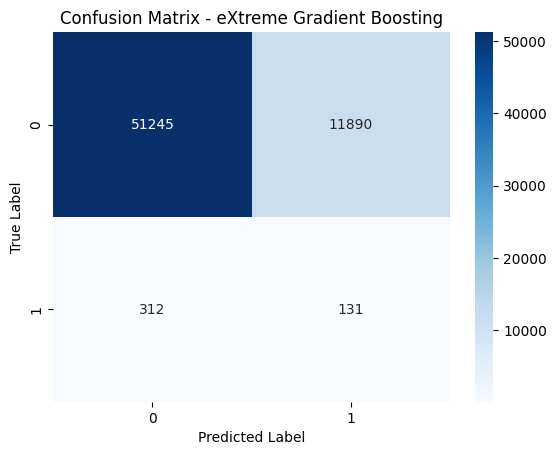

In [60]:
conf_matrix_xgb = confusion_matrix(Y_test, y_pred_xgb)
print(conf_matrix_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - eXtreme Gradient Boosting')
plt.show()

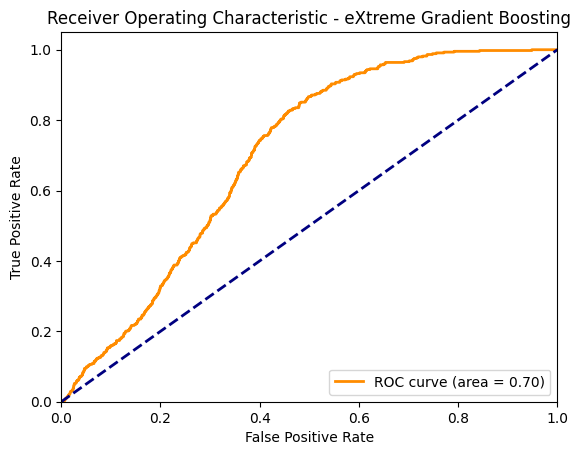

In [61]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(Y_test, y_prob_xgb)

roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - eXtreme Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

Similarly to the LGBM, given the outcome of the confusion matrix, the shape of the ROC curve, and the value of the AUC, we cannot consider the eXtreme Gradient Boosting model for our exercise.

### 6. Gaussian Naive Bayes

In [62]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(X_train, Y_train.values.ravel())
Y_Pred_gnb = gnb.predict(X_test)
print("Gaussian Naive Bayes Accuracy:", accuracy_score(Y_test, Y_Pred_gnb))

Gaussian Naive Bayes Accuracy: 0.8683192299223002


[[54973  8162]
 [  210   233]]


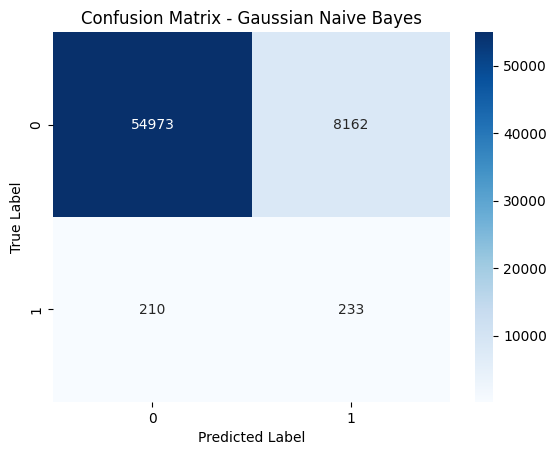

In [63]:
conf_matrix_gnb = confusion_matrix(Y_test, Y_Pred_gnb)
print(conf_matrix_gnb)
sns.heatmap(conf_matrix_gnb, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

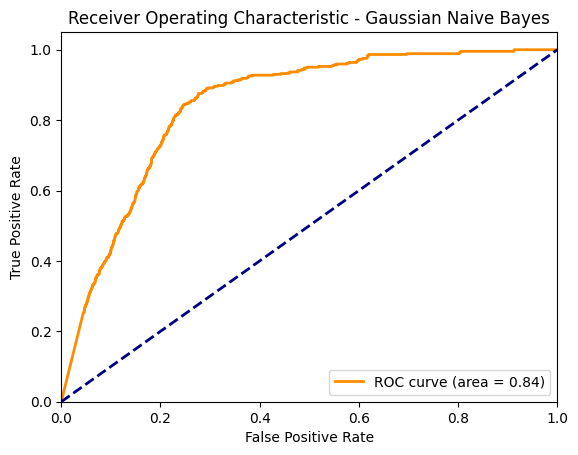

In [64]:
Prob_gnb = gnb.predict_proba(X_test)[:, 1]
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(Y_test, Prob_gnb)

roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

plt.figure()
plt.plot(fpr_gnb, tpr_gnb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gnb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()

The Gaussian Naive Bayes model has a good performance when predicting true positives and true negatives, as shown by the confusion matrix, as well as the ROC curve. For this, it is still under consideration.

### 7. Neural Networks

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(X_train_res, Y_train_res, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc}')

2024-04-03 20:15:16.563506: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 20:15:16.948293: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 20:15:18.303320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10060/10060 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7985 - loss: 0.4146 - val_accuracy: 0.8680 - val_loss: 0.4133
Epoch 2/10
10060/10060 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8406 - loss: 0.3419 - val_accuracy: 0.8877 - val_loss: 0.3878
Epoch 3/10
10060/10060 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8538 - loss: 0.3197 - val_accuracy: 0.8630 - val_loss: 0.4053
Epoch 4/10
10060/10060 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8584 - loss: 0.3080 - val_accuracy: 0.9223 - val_loss: 0.2953
Epoch 5/10
10060/10060 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8625 - loss: 0.3005 - val_accuracy: 0.8783 - val_loss: 0.3664
Epoch 6/10
10060/10060 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8649 - loss: 0.2934 - val_accuracy: 0.8907 - val_loss: 0.3422
Epoch 7/10
10060/10060 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8692 - loss: 0.2864 - val_accuracy: 0.8124 - val_loss: 0.4530
Epoch 8/10
10060/10060 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8708 - lo

1987/1987 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step
[[60784  2351]
 [  384    59]]


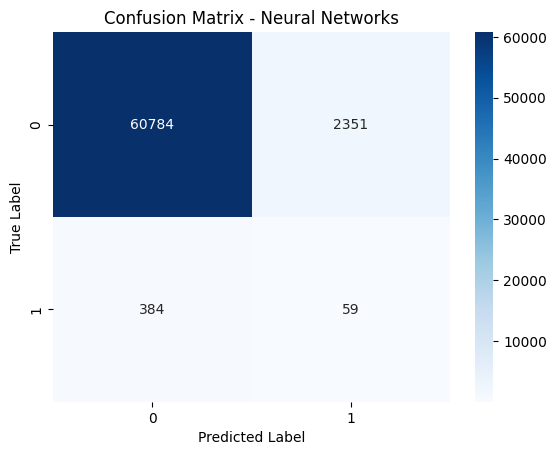

In [66]:
predictions_prob = model.predict(X_test)
predictions = np.round(predictions_prob).astype(int)

conf_matrix_nn = confusion_matrix(Y_test, predictions)
print(conf_matrix_nn)
sns.heatmap(conf_matrix_nn, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Neural Networks')
plt.show()

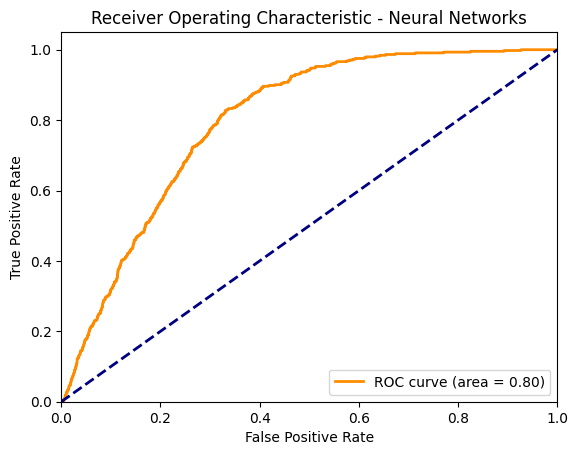

In [67]:
fpr_nn, tpr_nn, thresholds_nn = roc_curve(Y_test, predictions_prob)

roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure()
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Neural Networks')
plt.legend(loc="lower right")
plt.show()

Although it has a high accuracy, the confusion matrix and ROC curve of the Neural Network model shows that it is not the best fit for this problem.

### Model Conclusions

If we plot all the ROC Curves together, and also show the AUC values, we can see that while not perfect, the Balanced Random Forest performs the best out of all the models when considering  accuracy, confusion matrix results and ROC-AUC.

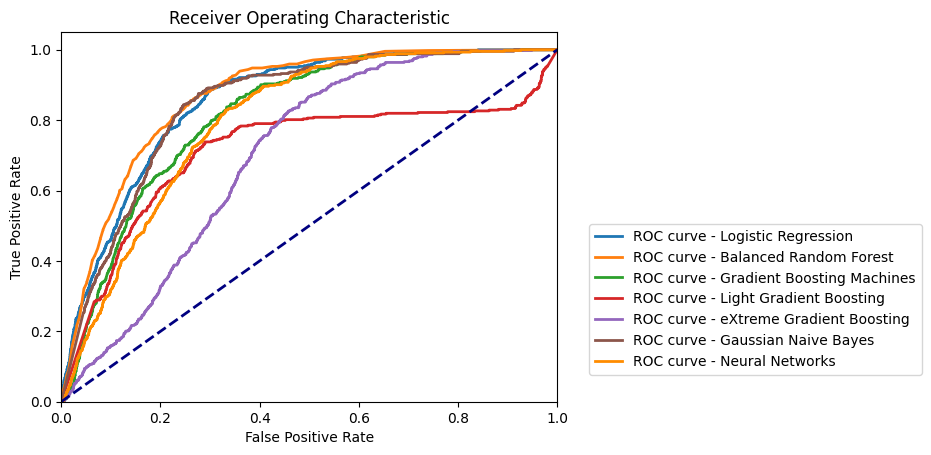

In [68]:
plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg, lw=2, label='ROC curve - Logistic Regression')
plt.plot(fpr_brf_100, tpr_brf_100, lw=2, label='ROC curve - Balanced Random Forest')
plt.plot(fpr_gbm, tpr_gbm, lw=2, label='ROC curve - Gradient Boosting Machines')
plt.plot(fpr_light_gbm, tpr_light_gbm, lw=2, label='ROC curve - Light Gradient Boosting')
plt.plot(fpr_xgb, tpr_xgb, lw=2, label='ROC curve - eXtreme Gradient Boosting')
plt.plot(fpr_gnb, tpr_gnb, lw=2, label='ROC curve - Gaussian Naive Bayes')
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label='ROC curve - Neural Networks')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.show()

In [69]:
print('ROC curve - Logistic Regression Area = %0.2f' % roc_auc_log_reg)
print('ROC curve - Balanced Random Forest Area = %0.2f' % roc_auc_brf_100)
print('ROC curve - Gradient Boosting Machines = %0.2f' % roc_auc_gbm)
print('ROC curve - Light Gradient Boosting = %0.2f' % roc_auc_light_gbm)
print('ROC curve - eXtreme Gradient Boosting = %0.2f' % roc_auc_xgb)
print('ROC curve - Gaussian Naive Bayes = %0.2f' % roc_auc_gnb)
print('ROC curve - Neural Networks = %0.2f' % roc_auc_nn)

ROC curve - Logistic Regression Area = 0.85
ROC curve - Balanced Random Forest Area = 0.87
ROC curve - Gradient Boosting Machines = 0.81
ROC curve - Light Gradient Boosting = 0.71
ROC curve - eXtreme Gradient Boosting = 0.70
ROC curve - Gaussian Naive Bayes = 0.84
ROC curve - Neural Networks = 0.80


In my opinion, the Balanced Random Forest model is the right model to predict if users will make a purchase on the Google Merchandise  store in the following month.

## Prediction for 01.08.2017

The last requirement for the exercise is that a prediction be carried out for the 1st of August 2017. Similarly to what was done previously, we will prepare the data in the same manner as the training and testing data. Steps are the same as described in the sections above.

In [70]:
data_august = "Select * from bigquery-public-data.google_analytics_sample.ga_sessions_20170801"
data_august_df = client.query(data_august).to_dataframe()

In [71]:
data_august_df_v1 = data_august_df[['fullVisitorId', 'date', 'visitStartTime', 'totals', 'device', 'geoNetwork', 'socialEngagementType', 'trafficSource']]
columns = ('totals', 'trafficSource', 'device', 'geoNetwork')

for column in columns:
    df1_aug = data_august_df_v1[column].apply(pd.Series)
    temp_str_aug = column + '_'
    df1_aug.columns = [temp_str_aug + col_name for col_name in df1_aug.columns]
    data_august_df_v1 = pd.concat([data_august_df_v1, df1_aug], axis = 1)
    data_august_df_v1.drop([column], axis=1, inplace = True)

print(data_august_df_v1.shape)

(2556, 54)


In [72]:
data_august_df_v2 = data_august_df_v1[['fullVisitorId', 'date', 'visitStartTime', 'socialEngagementType', 'totals_hits', 'totals_visits', 'totals_pageviews','totals_timeOnSite','totals_sessionQualityDim','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'geoNetwork_city', 'geoNetwork_cityId',  'trafficSource_source', 'totals_transactions']]
data_august_df_v2.shape

(2556, 17)

In [73]:
check_na_df_aug = data_august_df_v2.isna()
columns = ('fullVisitorId', 'date', 'visitStartTime', 'totals_hits', 'totals_visits', 'totals_pageviews','device_browser','device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country', 'trafficSource_source', 'totals_transactions')

for column in columns:
    print(check_na_df_aug[column].value_counts())

fullVisitorId
False    2556
Name: count, dtype: int64
date
False    2556
Name: count, dtype: int64
visitStartTime
False    2556
Name: count, dtype: int64
totals_hits
False    2556
Name: count, dtype: int64
totals_visits
False    2556
Name: count, dtype: int64
totals_pageviews
False    2556
Name: count, dtype: int64
device_browser
False    2556
Name: count, dtype: int64
device_operatingSystem
False    2556
Name: count, dtype: int64
device_deviceCategory
False    2556
Name: count, dtype: int64
geoNetwork_country
False    2556
Name: count, dtype: int64
trafficSource_source
False    2556
Name: count, dtype: int64
totals_transactions
True     2513
False      43
Name: count, dtype: int64


In [74]:
data_august_df_v2 = data_august_df_v2.copy()
data_august_df_v2['totals_transactions'] = data_august_df_v2['totals_transactions'].fillna(0)

In [75]:
date_data_aug = pd.DataFrame({'dateDay': data_august_df_v2['date'].astype(str).str[-2:].astype(int)})
for i in range(data_august_df_v2.shape[0]):
    date_string = data_august_df_v2.loc[i, 'date']
    as_date = datetime.strptime(date_string, "%Y%m%d")
    if as_date.weekday() >= 5:
        date_data_aug.loc[i, 'isWeekend'] = 1
    else:
        date_data_aug.loc[i, 'isWeekend'] = 0
        
data_august_df_v2.insert(2, 'dateDay', date_data_aug['dateDay'])
data_august_df_v2.insert(3, 'isWeekend', date_data_aug['isWeekend'])

In [76]:
columns = ('trafficSource_source', 'device_browser', 'device_operatingSystem', 'device_deviceCategory', 'geoNetwork_country')

for column in columns:
    str_values_df[column] = pd.concat([str_values_df[column], data_august_df_v2[column]], ignore_index=True)

str_values_df.shape

(266006, 5)

In [77]:
data_august_df_v2 = data_august_df_v2.copy()

#For the training data:
for column in columns:
    temp_array = str_values_df[column].unique()
    index_of_not_set = np.where(temp_array == '(not set)')[0]
    temp_array = np.delete(temp_array, index_of_not_set)
    temp_dict = {}
    temp_dict['(not set)'] = 0
    
    if '0' in temp_array:
        index_of_0 = np.where(temp_array == '0')[0]
        temp_array = np.delete(temp_array, index_of_0)
        temp_dict['0'] = 0
    
    for i in range(len(temp_array)):
        temp_dict[temp_array[i]] = (i+1)
    temp_str = column + '_numeric'
    data_august_df_v2[temp_str] = data_august_df_v2[column].map(temp_dict)

In [78]:
data_august_df_v2['visitStartTime_hour'] = 0
data_august_df_v2 = data_august_df_v2.copy()
for i in data_august_df_v2.index:
    date_aug = datetime.fromtimestamp(data_august_df_v2.loc[i, 'visitStartTime'], tz=timezone.utc)
    data_august_df_v2.loc[i, 'visitStartTime_hour'] = int(date_aug.strftime('%H'))

In [79]:
columns = ('visitStartTime_hour', 'totals_pageviews', 'totals_hits', 'dateDay', 'trafficSource_source_numeric', 'device_browser_numeric', 'device_operatingSystem_numeric', 'device_deviceCategory_numeric', 'geoNetwork_country_numeric', 'totals_transactions')

for column in columns:
    data_august_df_v2[column] = scaler.fit_transform(data_august_df_v2[[column]])
    data_august_df_v2[column] = scaler.fit_transform(data_august_df_v2[[column]])

In [80]:
X_pred = data_august_df_v2[['dateDay', 'isWeekend', 'visitStartTime_hour', 'totals_hits', 'totals_pageviews', 'trafficSource_source_numeric', 'device_browser_numeric', 'device_operatingSystem_numeric', 'device_deviceCategory_numeric', 'geoNetwork_country_numeric', 'totals_transactions']]

In [81]:
X_pred_results = brf_100.predict(X_pred)

In [91]:
X_pred_unique, X_pred_counts = np.unique(X_pred_results, return_counts=True)
np.asarray((X_pred_unique.astype(int), X_pred_counts.astype(int))).T

array([[   0, 2239],
       [   1,  317]])